In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,RandomFlip,RandomRotation,RandomCrop,RandomContrast,RandomTranslation,RandomZoom,Dropout
from keras.optimizers import Adam,schedules
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
print(tf.__version__)
%matplotlib inline

2.9.2


In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
print(physical_devices)

tf.config.set_visible_devices(physical_devices[0], 'GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
 !wget --no-check-certificate \
  https://app.box.com/shared/static/bgjqppjtnbc8e7258rbnq0ch7fy27tp6.zip \
  -O /tmp/cars.zip

--2022-11-22 04:57:49--  https://app.box.com/shared/static/bgjqppjtnbc8e7258rbnq0ch7fy27tp6.zip
Resolving app.box.com (app.box.com)... 74.112.186.144
Connecting to app.box.com (app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/bgjqppjtnbc8e7258rbnq0ch7fy27tp6.zip [following]
--2022-11-22 04:57:49--  https://app.box.com/public/static/bgjqppjtnbc8e7258rbnq0ch7fy27tp6.zip
Reusing existing connection to app.box.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://dl2.boxcloud.com/d/1/b1!GPIm5w2RfnBg68YmtP5VJ12B-ReVpuz1Yc1qcounJ8vNtxbBnuSZtnEFMgePAIDolk5PSxfmnZrL795pStSJ88RWOqn9ZUOSArXrh11stoyNrHss6tMy6bGIwao5nfXB78MQsW3FU9RwIjaOinjwWR6VIOnZdNpfDIHevP3JX7xGHsoIqZ9MboY_2tRyMtUSiHa83i-SY3Nf9kGdBiHVvqDhy_34Ja6PQYSxxP98isR3eikcHAcc9zcGzIYCn4sPsjOt5c_eRjacNYEE-JR7obtUeQ585TdnMOC0HIujedp2rexjPRoCD5X5rgwBoi4EXP8xxy46QUmT0TzEPtHhZHy4SjN4IlsBrmOw1kG20cYaOCg8PXua0p87DaoRXM_JY2gDdOIPcaK02MrEMNSY

In [ ]:
import os
import zipfile

local_zip = '/tmp/cars.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
base_path = '/tmp/cars'
train_path = os.path.join(base_path, 'train')
valid_path = os.path.join(base_path, 'valid')
test_path = os.path.join(base_path, 'test')
#Preprocessing allows for generalization, "stress" the neural network with sth harder, so when it comes to the actual thing, the neural network would work better


In [ ]:
IDG=ImageDataGenerator(rescale=1./225,rotation_range=200, horizontal_flip=True,vertical_flip=True, fill_mode='reflect',shear_range=0.2,zoom_range=0.1)
train_batches = IDG.flow_from_directory(directory=train_path, target_size=(224,224), classes=['BMW', 'Bugatti', 'Lamborghini','McLaren','Volkswagen'], batch_size=10)

valid_batches = IDG.flow_from_directory(directory=valid_path, target_size=(224,224), classes=['BMW', 'Bugatti', 'Lamborghini','McLaren','Volkswagen'], batch_size=10)

test_batches = IDG.flow_from_directory(directory=test_path, target_size=(224,224), classes=['BMW', 'Bugatti', 'Lamborghini','McLaren','Volkswagen'], batch_size=10,shuffle=False)
 #There are 3 channels which are RGB, thus input shape is (224,224,3)

Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [ ]:
imgs, labels = next(train_batches)
print(imgs)
test_batches.class_indices

[[[[0.08603662 0.09103037 0.09827133]
   [0.06764001 0.07541585 0.07152794]
   [0.08614786 0.08614786 0.08614786]
   ...
   [0.09824394 0.10713282 0.10268838]
   [0.09611687 0.10418183 0.10014934]
   [0.09754963 0.10340768 0.10047866]]

  [[0.0589747  0.06499268 0.06916095]
   [0.0600927  0.06582008 0.06295639]
   [0.07000363 0.07000363 0.07000363]
   ...
   [0.11619466 0.12508355 0.1206391 ]
   [0.11503375 0.12392264 0.1194782 ]
   [0.11692757 0.12581646 0.12137201]]

  [[0.0573006  0.06434281 0.0654384 ]
   [0.05678903 0.06046795 0.05862848]
   [0.02549956 0.02549956 0.02549956]
   ...
   [0.14165127 0.15054016 0.14609572]
   [0.1425893  0.15147819 0.14703375]
   [0.14370488 0.15259376 0.14814931]]

  ...

  [[0.9066667  0.9066667  0.9066667 ]
   [0.9066667  0.9066667  0.9066667 ]
   [0.9066667  0.9066667  0.9066667 ]
   ...
   [0.9066667  0.9066667  0.9066667 ]
   [0.9066667  0.9066667  0.9066667 ]
   [0.9066667  0.9066667  0.9066667 ]]

  [[0.9066667  0.9066667  0.9066667 ]
   [0.9

{'BMW': 0, 'Bugatti': 1, 'Lamborghini': 2, 'McLaren': 3, 'Volkswagen': 4}

In [ ]:
# This function will plot images in the form of a grid with 1 row and 10 columns
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

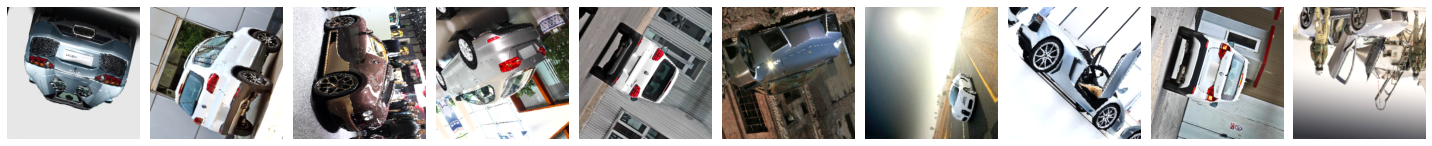

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [ ]:
plotImages(imgs)
print(labels)

In [ ]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [ ]:
#Source code taken from https://github.com/Tony607/keras_mixup_generator
#Edits were made to fit our classification problem 
import numpy as np

class MixupImageDataGenerator():
    def __init__(self, generator, directory, batch_size, img_height, img_width, classes, alpha=0.2, subset=None,): #"Classes" were added
        """Constructor for mixup image data generator.
        Arguments:
            generator {object} -- An instance of Keras ImageDataGenerator.
            directory {str} -- Image directory.
            batch_size {int} -- Batch size.
            img_height {int} -- Image height in pixels.
            img_width {int} -- Image width in pixels.
        Keyword Arguments:
            alpha {float} -- Mixup beta distribution alpha parameter. (default: {0.2})
            subset {str} -- 'training' or 'validation' if validation_split is specified in
            `generator` (ImageDataGenerator).(default: {None})
        """

        self.batch_index = 0
        self.batch_size = batch_size
        self.alpha = alpha

        # First iterator yielding tuples of (x, y)
        self.generator1 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        classes=classes, #Edits were made here
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        # Second iterator yielding tuples of (x, y)
        self.generator2 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        classes=classes, #Edits were made here
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        # Number of images across all classes in image directory.
        self.n = self.generator1.samples

    def reset_index(self):
        """Reset the generator indexes array.
        """

        self.generator1._set_index_array()
        self.generator2._set_index_array()

    def on_epoch_end(self):
        self.reset_index()

    def reset(self):
        self.batch_index = 0

    def __len__(self):
        # round up
        return (self.n + self.batch_size - 1) // self.batch_size

    def get_steps_per_epoch(self):
        """Get number of steps per epoch based on batch size and
        number of images.
        Returns:
            int -- steps per epoch.
        """
        return self.n // self.batch_size

    def __next__(self):
        """Get next batch input/output pair.
        Returns:
            tuple -- batch of input/output pair, (inputs, outputs).
        """

        if self.batch_index == 0:
            self.reset_index()

        current_index = (self.batch_index * self.batch_size) % self.n
        if self.n > current_index + self.batch_size:
            self.batch_index += 1
        else:
            self.batch_index = 0

        # random sample the lambda value from beta distribution.
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)

        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        # Get a pair of inputs and outputs from two iterators.
        X1, y1 = self.generator1.next()
        X2, y2 = self.generator2.next()

        # Perform the mixup.
        X = X1 * X_l + X2 * (1 - X_l)
        y = y1 * y_l + y2 * (1 - y_l)
        return X, y

    def __iter__(self):
        while True:
            yield next(self)

In [ ]:
train_iterator=MixupImageDataGenerator(generator=IDG,directory=train_path,batch_size=10, img_height=224,img_width=224,classes=['BMW', 'Bugatti', 'Lamborghini','McLaren','Volkswagen'])

Found 400 images belonging to 5 classes.
Found 400 images belonging to 5 classes.


In [ ]:
img, label = next(train_iterator)
print(type(img))

<class 'numpy.ndarray'>


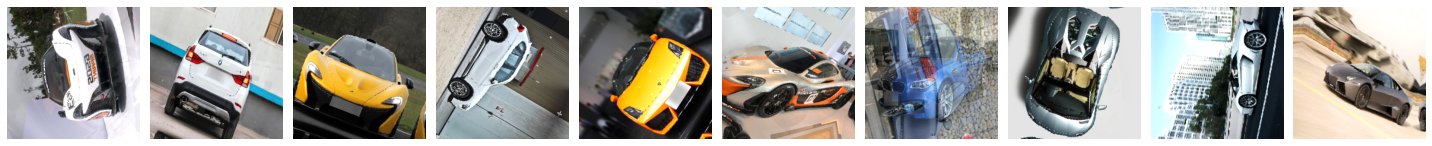

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00]
 [9.26174965e-01 0.00000000e+00 7.38250346e-02 0.00000000e+00
  0.00000000e+00]
 [1.00935578e-04 0.00000000e+00 0.00000000e+00 9.99899064e-01
  0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.91485625e-01 8.51437538e-03
  0.00000000e+00]
 [7.40933678e-02 0.00000000e+00 0.00000000e+00 9.25906632e-01
  0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 5.74586427e-08 9.99999943e-01 0.00000000e+00
  0.00000000e+00]
 [3.15267033e-03 0.00000000e+00 9.96847330e-01 0.00000000e+00
  0.00000000e+00]]


In [ ]:
plotImages(img)
print(label)

In [ ]:
data_augmentation = Sequential([
  RandomFlip("horizontal_and_vertical",input_shape=(224,224,3)),
  RandomRotation(factor=0.5),
  RandomTranslation(height_factor=(0.1),
    width_factor=(0.1),
    fill_mode='wrap',
    interpolation='bilinear',
    seed=None,)])
data_augmentation.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_translation (RandomT  (None, 224, 224, 3)      0         
 ranslation)                                                     
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


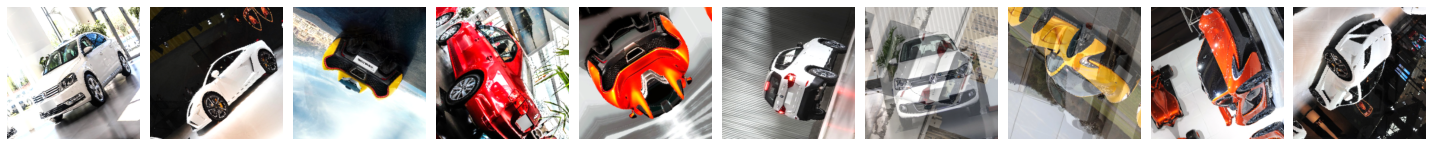

[[0.00000000e+00 0.00000000e+00 2.53260109e-07 0.00000000e+00
  9.99999747e-01]
 [0.00000000e+00 0.00000000e+00 9.82780048e-01 0.00000000e+00
  1.72199518e-02]
 [0.00000000e+00 6.59724038e-02 0.00000000e+00 9.34027596e-01
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [4.01097795e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  5.98902205e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.19435602e-01
  2.80564398e-01]
 [0.00000000e+00 4.10178520e-02 0.00000000e+00 9.58982148e-01
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.52092903e-01 0.00000000e+00
  4.79070970e-02]]


In [ ]:
img, label = next(train_iterator)
augmented_images = data_augmentation(img)
plotImages(img)
print(label)

In [ ]:
model1 = Sequential(
    [data_augmentation,    
    Conv2D(filters=32,kernel_size=(3,3),activation ='relu', padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2),strides=2),
    Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'),
    MaxPool2D(pool_size=(2,2),strides=2),
    Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'),
    MaxPool2D(pool_size=(2,2),strides=2),
    Flatten(),
    Dense(units=5,activation='softmax')]  
)
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)      

In [ ]:
model1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
A=train_iterator.get_steps_per_epoch()
print(A)

40


In [ ]:
history1=model1.fit(x=train_iterator, validation_data=valid_batches, epochs=300, verbose=1,steps_per_epoch=A)

Epoch 1/300


40/40 [==============================] - 37s 639ms/step - loss: 1.6205 - accuracy: 0.1975 - val_loss: 1.5826 - val_accuracy: 0.2300
Epoch 2/300
40/40 [==============================] - 17s 436ms/step - loss: 1.5595 - accuracy: 0.2800 - val_loss: 1.5538 - val_accuracy: 0.2600
Epoch 3/300
40/40 [==============================] - 19s 487ms/step - loss: 1.4856 - accuracy: 0.3375 - val_loss: 1.5236 - val_accuracy: 0.3700
Epoch 4/300
40/40 [==============================] - 17s 438ms/step - loss: 1.4491 - accuracy: 0.3475 - val_loss: 1.4848 - val_accuracy: 0.2900
Epoch 5/300
40/40 [==============================] - 19s 495ms/step - loss: 1.3635 - accuracy: 0.4550 - val_loss: 1.4811 - val_accuracy: 0.3000
Epoch 6/300
40/40 [==============================] - 18s 456ms/step - loss: 1.3464 - accuracy: 0.4275 - val_loss: 1.3405 - val_accuracy: 0.3900
Epoch 7/300
40/40 [==============================] - 17s 436ms/step - loss: 1.2963 - accuracy: 0.4850 - val_loss: 1.4099 - val_accuracy: 0.3800
Epoc

In [ ]:
y_test = test_batches.classes
print(type(y_test))
print(y_test)

<class 'numpy.ndarray'>
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [ ]:
output_layer1 = model1.predict(x=test_batches, verbose=0)
np.round(output_layer1)

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1.

In [ ]:
y_pred1 = np.argmax(output_layer1, axis=-1)
print(y_pred1)

[0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 4 0 1 1 1 1 1 1 1 1 2 1 1 1 3 1 1 1 1
 3 1 1 1 2 4 1 2 3 2 1 2 0 2 0 2 2 2 2 2 2 4 2 3 1 3 3 3 3 3 3 1 3 4 3 3 3
 3 3 3 2 2 3 4 4 4 0 4 4 0 4 4 4 4 4 4 4 4 4 4 4 4 4]


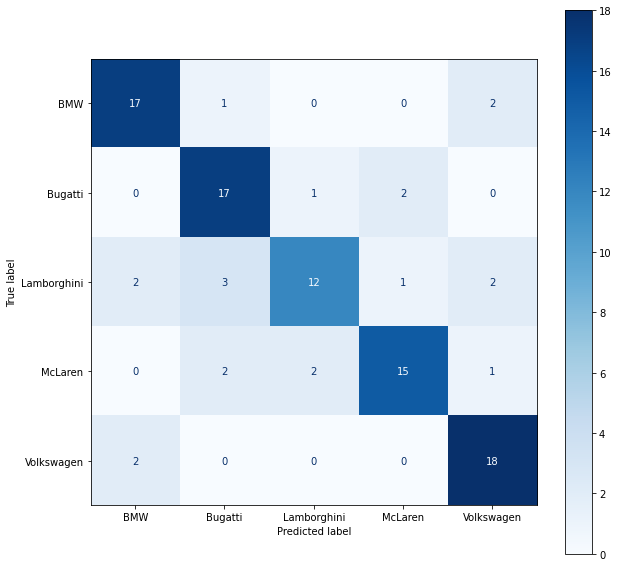

In [ ]:
cm1 = confusion_matrix(y_test, y_pred1)

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=['BMW', 'Bugatti', 'Lamborghini','McLaren','Volkswagen'])
fig, ax = plt.subplots(figsize=(10,10))
disp1.plot(ax=ax,cmap=plt.cm.Blues)

In [ ]:
Accuracy = accuracy_score(y_test, y_pred1)
print(Accuracy)

0.79


In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred1, target_names=['BMW', 'Bugatti', 'Lamborghini','McLaren','Volkswagen']))


Classification Report

              precision    recall  f1-score   support

         BMW       0.81      0.85      0.83        20
     Bugatti       0.74      0.85      0.79        20
 Lamborghini       0.80      0.60      0.69        20
     McLaren       0.83      0.75      0.79        20
  Volkswagen       0.78      0.90      0.84        20

    accuracy                           0.79       100
   macro avg       0.79      0.79      0.79       100
weighted avg       0.79      0.79      0.79       100



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


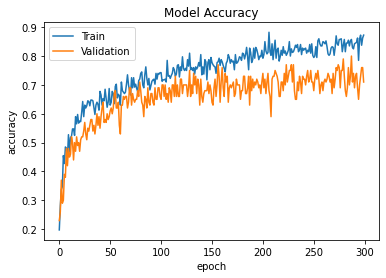

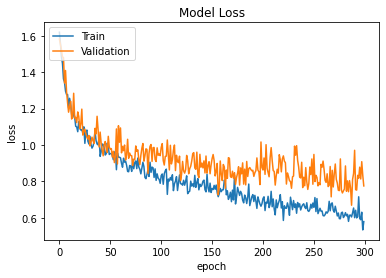

In [ ]:
#Suggesion is from:https://machinelearningmastery.com/improve-deep-learning-performance/
#Code is from:https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

print(history1.history.keys())
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy']) 
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')#The history for the validation dataset is labeled test by convention as it is indeed a test dataset for the model.
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()